In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2

In [2]:
def load_dataset(dsname: str):
    df = pd.read_csv(f'data/{dsname}.csv')
    X = df[['x', 'y']].to_numpy()
    y = df['class'].replace(['P', 'N'], [1, -1]).to_numpy()
    return X, y

Опишем ядра в файле `kernels.py`, а саму имплементацию SVM - в файле `svm.py`.

In [3]:
import kernels
import svm

Посмотрим что наша имплементация вообще работает:

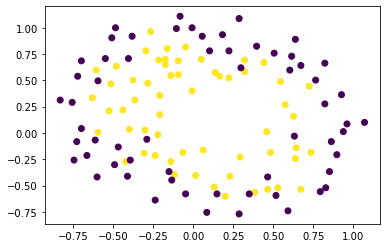

In [4]:
X, y = load_dataset('chips')

plt.scatter(X[:,0], X[:,1], c=y)

In [5]:
from sklearn.metrics import accuracy_score as acc_score

# kernel = kernels.Linear()
kernel = kernels.Polynomial(gamma=.5, r=.5, d=5)

model = svm.SVMIter(kernel, 50, max_iter=1000)

model.fit(X, y)

y_pred = model.predict(X)

acc_score(y, y_pred)

0.847457627118644

Довольно дерьмово (но это потому что ядро линейное), давайте попробуем нарисовать разделение поверхностей:

In [6]:
from matplotlib.colors import ListedColormap as LCmap

def division(model, lbx=-1., lby=-1., rtx=1., rty=1., step=0.01):
    xx, yy = np.meshgrid(np.arange(lbx, rtx, step),
                         np.arange(lby, rty, step))
    
    mesh_dots = np.c_[xx.ravel(), yy.ravel()]
    zz = model.predict(mesh_dots)
    zz = np.array(zz).reshape(xx.shape)
    
    plt.figure(figsize=(10, 10))
    plt.xlim(lbx, rtx)
    plt.ylim(lby, rty)
    
    plt.pcolormesh(xx, yy, zz, cmap=LCmap(['#FFFAAA', '#AAAFFF']))

/home/covariance/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  from ipykernel import kernelapp as app


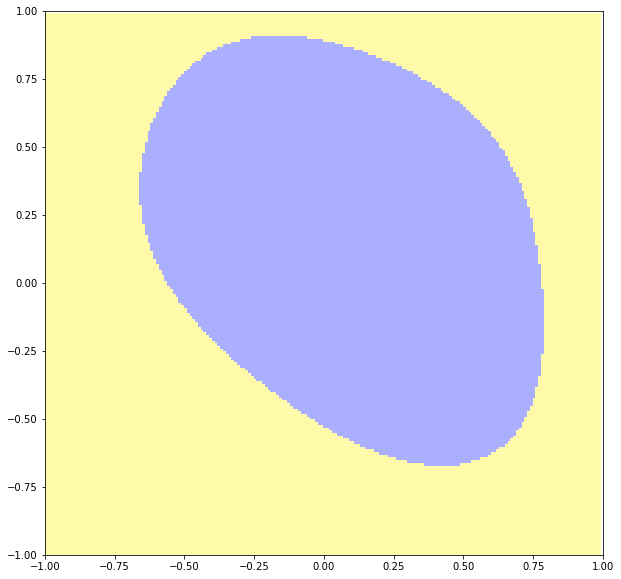

In [7]:
division(model)

Казалось бы, при чем здесь?..

Давайте теперь устроим гридсёрч!

Как можно видеть, наша модель соответствует интерфейсу sklearn-а:

In [8]:
from sklearn.utils.estimator_checks import check_estimator

# check_estimator(model)
# ну тут слишком много всякого набросали

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pipe = Pipeline([
    ('svm', svm.SVMIter(kernels.Linear(), 1))
])

poly_kernels = [kernels.Polynomial(gamma=gamma, r=r, d=d) 
                for gamma in np.arange(0.1, 1.1, 3)
                for r in np.arange(0.1, 1.1, 3)
                for d in range(1, 6)
               ]

rbf_kernels = [kernels.RBF(gamma=gamma) for gamma in np.arange(0.1, 2.1, 10)]

param_grid = {
    'svm__kernel_f': [kernels.Linear()] + poly_kernels + rbf_kernels,
    'svm__C'       : (.1, 1, 10, 50, 100),
    'svm__max_iter': (10, 100, 1000),
}

In [10]:
def find_best(data: str):
    X, y = load_dataset(data)
    search = GridSearchCV(pipe, param_grid, n_jobs=4, scoring='accuracy', verbose=3, refit=True)
    search.fit(X, y)
    
    print(f'\n\nBest parameter (CV score={search.best_score_:.4})')
    print(search.best_params_)
    print('\n\n')
    
    return search

In [11]:
chips_best = find_best('chips')

Fitting 5 folds for each of 105 candidates, totalling 525 fits
[CV 4/5] END svm__C=0.1, svm__kernel_f=<kernels.Linear object at 0x7f127960ce90>, svm__max_iter=10;, score=0.478 total time=   0.1s
[CV 4/5] END svm__C=0.1, svm__kernel_f=<kernels.Linear object at 0x7f127960cf10>, svm__max_iter=100;, score=0.261 total time=   0.2s
[CV 3/5] END svm__C=0.1, svm__kernel_f=<kernels.Linear object at 0x7f127960c7d0>, svm__max_iter=1000;, score=0.375 total time=   1.6s
[CV 2/5] END svm__C=0.1, svm__kernel_f=<kernels.Polynomial object at 0x7f127960ce90>, svm__max_iter=10;, score=0.500 total time=   0.1s
[CV 4/5] END svm__C=0.1, svm__kernel_f=<kernels.Polynomial object at 0x7f127960ccd0>, svm__max_iter=10;, score=0.478 total time=   0.1s
[CV 1/5] END svm__C=0.1, svm__kernel_f=<kernels.Polynomial object at 0x7f127960cbd0>, svm__max_iter=100;, score=0.125 total time=   0.2s
[CV 4/5] END svm__C=0.1, svm__kernel_f=<kernels.Polynomial object at 0x7f127960cbd0>, svm__max_iter=100;, score=0.261 total time=

In [12]:
acc_score(chips_best.predict(X), y)

0.8135593220338984

Accuracy: 0.8136


/home/covariance/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  from ipykernel import kernelapp as app


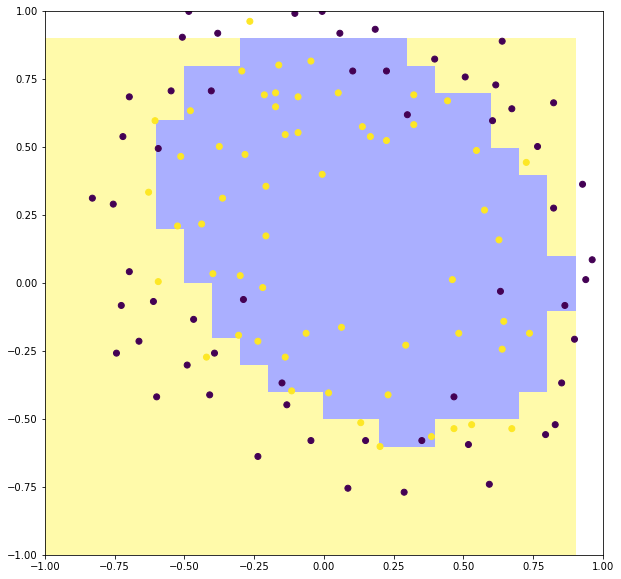

In [13]:
X, y = load_dataset('chips')
print(f'Accuracy: {acc_score(chips_best.predict(X), y):.4}')
division(chips_best, step=.1)
plt.scatter(X[:,0], X[:,1], c=y)
plt.show()

In [14]:
geyser_best = find_best('geyser')

Fitting 5 folds for each of 105 candidates, totalling 525 fits

[CV 5/5] END svm__C=10, svm__kernel_f=<kernels.Polynomial object at 0x7f07055fbe50>, svm__max_iter=1000;, score=0.522 total time=   2.3s
[CV 4/5] END svm__C=10, svm__kernel_f=<kernels.RBF object at 0x7f07055fbd90>, svm__max_iter=1000;, score=0.652 total time=   2.3s
[CV 5/5] END svm__C=50, svm__kernel_f=<kernels.Linear object at 0x7f07055fb810>, svm__max_iter=100;, score=0.435 total time=   0.3s
[CV 3/5] END svm__C=50, svm__kernel_f=<kernels.Linear object at 0x7f07055fbbd0>, svm__max_iter=1000;, score=0.375 total time=   2.4s
[CV 5/5] END svm__C=50, svm__kernel_f=<kernels.Linear object at 0x7f07055fbb10>, svm__max_iter=1000;, score=0.391 total time=   2.3s
[CV 4/5] END svm__C=50, svm__kernel_f=<kernels.Polynomial object at 0x7f07055fbf10>, svm__max_iter=1000;, score=0.348 total time=   2.1s
[CV 1/5] END svm__C=50, svm__kernel_f=<kernels.Polynomial object at 0x7f07055fb750>, svm__max_iter=1000;, score=0.583 total time=   2.

Accuracy: 0.8964


/home/covariance/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  from ipykernel import kernelapp as app


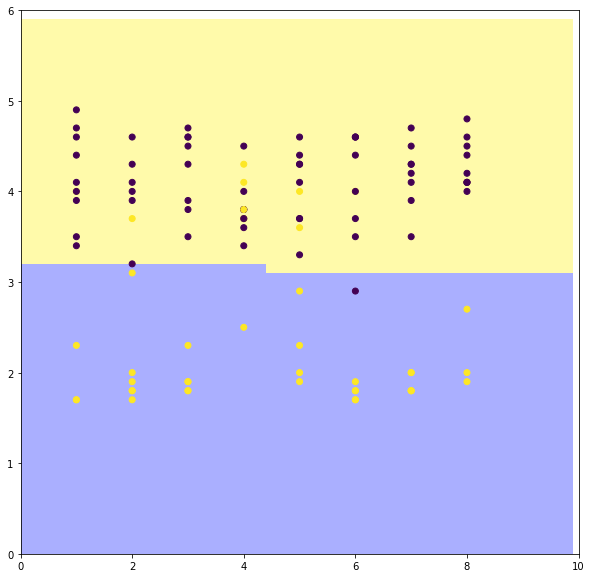

In [15]:
X, y = load_dataset('geyser')
print(f'Accuracy: {acc_score(geyser_best.predict(X), y):.4}')
division(geyser_best, 0, 0, 10, 6, .1)
plt.scatter(X[:,0], X[:,1], c=y)
plt.show()